# Import Libraries

In [25]:
import os
import sys
import pandas as pd

from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Prepare data

In [26]:
path_dir = os.path.dirname(os.path.abspath(''))

In [27]:
sys.path.append(os.path.join(path_dir, 'scripts\\common'))
import tool

In [28]:
binary_columns      = ['Sex']

data = pd.read_csv(os.path.join(path_dir, 'data\\data_final_lite.csv')).drop(['ID', 'Congestive heart failure'], axis=1)

y = data['CHA2DS2-VASc']
X = data.drop('CHA2DS2-VASc', axis=1)

In [29]:
y[y == 2] = 1

C:\Users\nperc\AppData\Local\Temp\ipykernel_24776\1154579384.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y == 2] = 1


## Preprocessing

In [30]:
preprocessor = tool.make_preprocess(X, binary_columns)

X = preprocessor.fit_transform(X)

## Model definition

In [31]:
lr_model = LogisticRegression

lr_param = {"C":[0.001, 0.01, 0.1, 1, 10, 100, 1000], "solver":["newton-cg", "lbfgs", "liblinear"], "penalty":["l2"]}

In [32]:
tree_model = DecisionTreeClassifier

tree_param = {
    'max_features'  : ['sqrt', 'log2'],
    'ccp_alpha'     : [0.1, .01, .001],
    'max_depth'     : [2, 4, 6, 8, 10, 12],
    'criterion'     : ['gini', 'entropy']
    }

In [33]:
forest_model = RandomForestClassifier

forest_param = {
    'bootstrap'         : [True, False],
    'max_depth'         : [8, 10, 12, 15],
    'max_features'      : ['sqrt', 'log2'],
    'ccp_alpha'         : [0.1, .01, .001],
    'n_estimators'      : [20, 50],
    'criterion'         : ['gini', 'entropy']
    }

In [34]:
svc_model = SVC

svc_param = {
    'C'         :[0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'gamma'     :[1,0.1,0.001,0.0001],
    'kernel'    :['linear', 'poly', 'rbf', 'sigmoid']
}

### Split dataset to find best parameters

In [35]:
nb_fold = 5

In [36]:
index_train, index_test             = tool.dataset_split_index(X, y, fold=nb_fold)

## Find best parameters

In [37]:
k_neighbors_smote = None

In [38]:
lr_report, lr_index_fold                = tool.find_best_grid(lr_model(random_state=42), X, y, index_train, index_test, param=lr_param, k_neighbors_smote=k_neighbors_smote)
tree_report, tree_index_fold            = tool.find_best_grid(tree_model(random_state=42), X, y, index_train, index_test, param=tree_param, k_neighbors_smote=k_neighbors_smote)
forest_report, forest_index_fold        = tool.find_best_grid(forest_model(random_state=42), X, y, index_train, index_test, param=forest_param, k_neighbors_smote=k_neighbors_smote)
svc_report, svc_index_fold              = tool.find_best_grid(svc_model(random_state=42), X, y, index_train, index_test, param=svc_param, k_neighbors_smote=k_neighbors_smote)

### Function to train model and display the metrics

In [39]:
def train_pred(model, report, X, y, index_fold) :
    
    X_train, y_train, X_test, y_test = tool.split_train(X, y, index_train[index_fold], index_test[index_fold])
    
    if model == SVC :
        model       = model(**report['best_grid'], random_state=42, probability=True)
    else :
        model       = model(**report['best_grid'], random_state=42)
    
    model.fit(X_train, y_train)
    y_pred      = model.predict(X_test)
    
    print('Mean accuracy : ' + str(report['best_mean_score']))
    print('Standard deviation : ' + str(report['best_st_score']))
    print('Accuracy : ' + str(accuracy_score(y_test, y_pred)))
    print(confusion_matrix(y_test, y_pred))
    
    return model

In [40]:
import matplotlib.pyplot as plt

def display_roc_curve(model, X_test, y_test) :

    score = model.predict_proba(X_test)[:,1]

    from sklearn.metrics import roc_curve, auc, RocCurveDisplay


    fpr, tpr, thresholds = roc_curve(y_test, score, pos_label=None)

    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                    estimator_name='example estimator')
    display.plot()

    plt.show()

## Logistic Regression

In [41]:
lr_model_roc = train_pred(lr_model, lr_report, X, y, lr_index_fold)

Mean accuracy : 0.8444444444444444
Standard deviation : 0.052135304648743226
Accuracy : 0.9191919191919192
[[48  4]
 [ 4 43]]


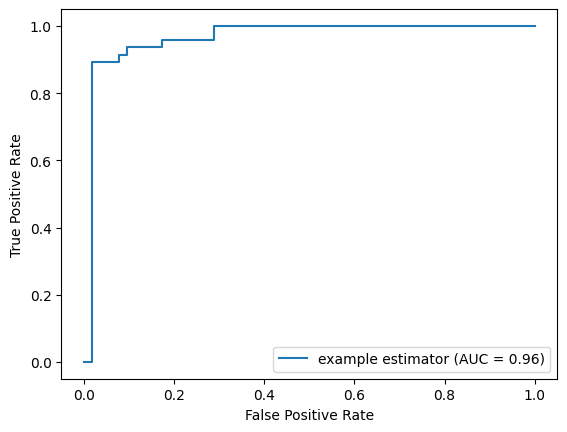

In [42]:
lr_X_train, lr_y_train, lr_X_test, lr_y_test = tool.split_train(X, y, index_train[lr_index_fold], index_test[lr_index_fold])

display_roc_curve(lr_model_roc, lr_X_test, lr_y_test)

## Decision Tree

In [43]:
tree_model_roc = train_pred(tree_model, tree_report, X, y, tree_index_fold)

Mean accuracy : 0.7575757575757576
Standard deviation : 0.029964438331699636
Accuracy : 0.7878787878787878
[[51  7]
 [14 27]]


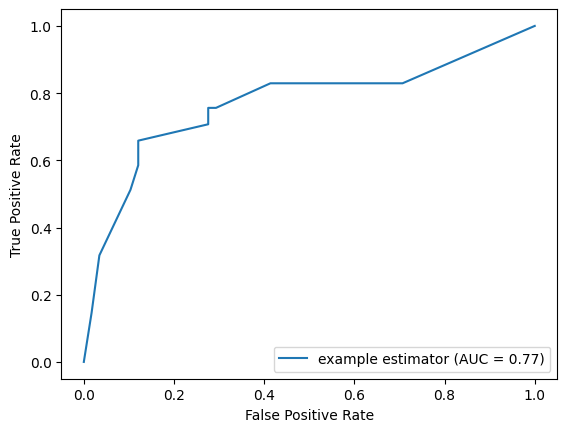

In [44]:
tree_X_train, tree_y_train, tree_X_test, tree_y_test = tool.split_train(X, y, index_train[tree_index_fold], index_test[tree_index_fold])

display_roc_curve(tree_model_roc, tree_X_test, tree_y_test)

## Random Forest

In [45]:
forest_model_roc = train_pred(forest_model, forest_report, X, y, forest_index_fold)

Mean accuracy : 0.8080808080808082
Standard deviation : 0.023033846971699776
Accuracy : 0.8282828282828283
[[49  8]
 [ 9 33]]


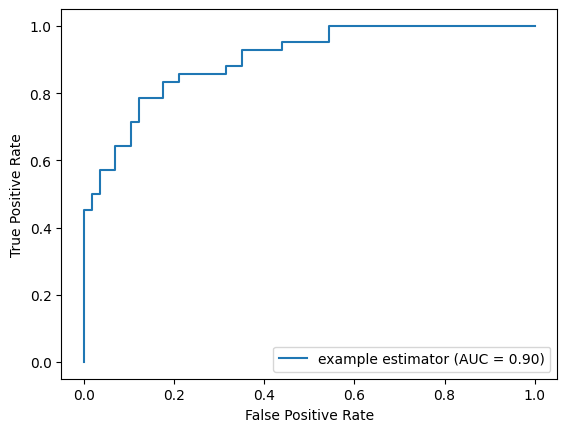

In [46]:
forest_X_train, forest_y_train, forest_X_test, forest_y_test = tool.split_train(X, y, index_train[forest_index_fold], index_test[forest_index_fold])

display_roc_curve(forest_model_roc, forest_X_test, forest_y_test)

## SVC

In [47]:
svc_model_roc = train_pred(svc_model, svc_report, X, y, svc_index_fold)

Mean accuracy : 0.8424242424242425
Standard deviation : 0.05174241808026547
Accuracy : 0.9191919191919192
[[48  4]
 [ 4 43]]


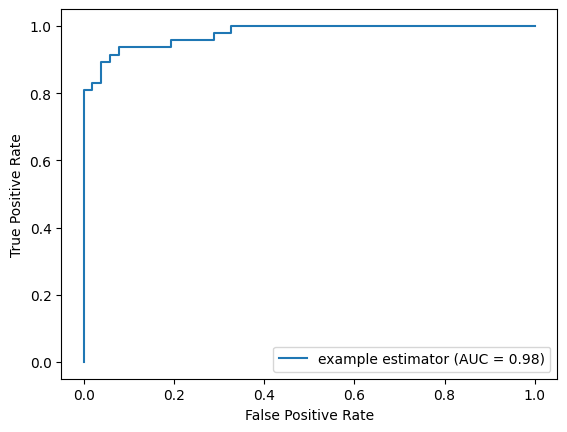

In [48]:
svc_X_train, svc_y_train, svc_X_test, svc_y_test = tool.split_train(X, y, index_train[svc_index_fold], index_test[svc_index_fold])

display_roc_curve(svc_model_roc, svc_X_test, svc_y_test)